In [1]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import LogisticRegression
from sklearn.utils.validation import check_is_fitted
import torch
torch.set_default_device("cuda")

class MultinomialSyntheticDataGenerator(BaseEstimator, ClassifierMixin):
    def __init__(self, random_state=None):
        """
        A custom estimator for generating synthetic data using multinomial logistic regression,
        with the feature distribution inferred from the training data.
        
        Parameters:
        - n_samples (int): Number of synthetic samples to generate.
        - random_state (int): Seed for reproducibility.
        """
        self.random_state = random_state
        np.random.seed(self.random_state)


    def fit(self, X, y):
        """
        Fits a multinomial logistic regression model to the data and estimates the feature distribution.
        
        Parameters:
        - X (ndarray): Feature matrix of shape (n_samples, n_features).
        - y (ndarray): Target labels of shape (n_samples,).
        
        Returns:
        - self: The fitted instance.
        """
        # Store mean and covariance of features
        self.classes_ = np.unique(y)
        self.feature_mean_ = np.mean(X, axis=0)
        self.feature_cov_ = np.cov(X, rowvar=False)
        
        # Fit a logistic regression model
        self.model_ = LogisticRegression(multi_class="multinomial", solver="lbfgs", random_state=self.random_state)
        self.model_.fit(X, y)
        
        # Store the number of classes and features
        self.n_classes_ = len(np.unique(y))
        self.n_features_ = X.shape[1]
        
        return self

    def predict_proba(self, X):
        """
        Predicts class probabilities for the given feature matrix.
        
        Parameters:
        - X (ndarray): Feature matrix of shape (n_samples, n_features).
        
        Returns:
        - probabilities (ndarray): Predicted probabilities of shape (n_samples, n_classes).
        """
        check_is_fitted(self, "model_")
        return self.model_.predict_proba(X)
    

    def predict(self, X):
        """
        Predicts class probabilities for the given feature matrix.
        
        Parameters:
        - X (ndarray): Feature matrix of shape (n_samples, n_features).
        
        Returns:
        - probabilities (ndarray): Predicted probabilities of shape (n_samples, n_classes).
        """
        check_is_fitted(self, "model_")
        return self.model_.predict(X)

    def generate(self, n):
        """
        Generates synthetic data and labels based on the learned model and feature distribution.
        
        Returns:
        - X_synthetic (ndarray): Generated feature matrix of shape (n_samples, n_features).
        - y_synthetic (ndarray): Generated labels of shape (n_samples,).
        """
        check_is_fitted(self, ["model_", "feature_mean_", "feature_cov_"])
        
        # Generate synthetic features based on the inferred distribution
        X_synthetic = np.random.multivariate_normal(self.feature_mean_, self.feature_cov_, n)
        
        # Compute class probabilities
        P_Y_given_X = self.predict_proba(X_synthetic)
        
        # Sample synthetic labels
        y_synthetic = np.array([np.random.choice(self.n_classes_, p=probs) for probs in P_Y_given_X])
        
        return X_synthetic, y_synthetic


    def generate_instances(self, n):
        """
        Generates synthetic data and labels based on the learned model and feature distribution.
        
        Returns:
        - X_synthetic (ndarray): Generated feature matrix of shape (n_samples, n_features).
        - y_synthetic (ndarray): Generated labels of shape (n_samples,).
        """
        check_is_fitted(self, ["model_", "feature_mean_", "feature_cov_"])
        
        # Generate synthetic features based on the inferred distribution
        
        X = np.random.multivariate_normal(self.feature_mean_, self.feature_cov_, n)
        return X



In [2]:
class OracleAnnotator:
    def __init__(self,mapie_clf, generator):
        self.mapie_clf = mapie_clf
        self.classes_ = mapie_clf.classes_
        self.generator = generator

    def generate_pairs_in_instance(self, n):
        """
        Generates synthetic data and labels based on the learned model and feature distribution.
        
        Returns:
        - X_synthetic (ndarray): Generated feature matrix of shape (n_samples, n_features).
        - y_synthetic (ndarray): Generated labels of shape (n_samples,).
        """        
        # Generate synthetic features based on the inferred distribution
        X = self.generator.generate_instances(n)
        X = np.repeat(X, repeats=2, axis=0)

        y = np.hstack([np.random.choice(self.classes_, size=2, replace=False) for _ in range(n)])

        conformities = self.get_conformity(X,y)

        X_rs = X.reshape(n,2,self.generator.n_features_)
        y_rs = y.reshape(n,2)
        conformities_n_rs = - conformities.reshape(n,2)
        sort_idx = conformities_n_rs.argsort(axis=1)
        X_rs[sort_idx]
        y_rs[sort_idx,:]
        X_pairs = np.take_along_axis(X_rs, sort_idx[:, :, np.newaxis], axis=1)
        y_pairs = np.expand_dims(np.take_along_axis(y_rs, sort_idx, axis=1),axis=-1)
        return X_pairs, y_pairs


    def generate_pairs_cross_instance(self, n):
        """
        Generates synthetic data and labels based on the learned model and feature distribution.
        
        Returns:
        - X_synthetic (ndarray): Generated feature matrix of shape (n_samples, n_features).
        - y_synthetic (ndarray): Generated labels of shape (n_samples,).
        """        
        # Generate synthetic features based on the inferred distribution
        
        X = self.generator.generate_instances(2*n)
        y = np.random.choice(self.classes_, size=2*n, replace=True)
        conformities = self.get_conformity(X,y)

        X_rs = X.reshape(n,2,self.generator.n_features_)
        y_rs = y.reshape(n,2)
        conformities_n_rs = - conformities.reshape(n,2)
        sort_idx = conformities_n_rs.argsort(axis=1)
        X_rs[sort_idx]
        y_rs[sort_idx,:]
        X_pairs = np.take_along_axis(X_rs, sort_idx[:, :, np.newaxis], axis=1)
        y_pairs = np.expand_dims(np.take_along_axis(y_rs, sort_idx, axis=1),axis=-1)

        return X_pairs, y_pairs
    
    # def create_pairs_for_classification_data(self, X):
    #     """
    #     Generates synthetic data and labels based on the learned model and feature distribution.
        
    #     Returns:
    #     - X_synthetic (ndarray): Generated feature matrix of shape (n_samples, n_features).
    #     - y_synthetic (ndarray): Generated labels of shape (n_samples,).
    #     """
    #     # Generate synthetic features based on the inferred distribution
        
    #     X = self.generator.generate_instances(2*n)
    #     y = np.random.choice(self.classes_, size=2*n, replace=True)
    #     conformities = self.get_conformity(X,y)

    #     X_rs = X.reshape(n,2,self.generator.n_features_)
    #     y_rs = y.reshape(n,2)
    #     conformities_n_rs = - conformities.reshape(n,2)
    #     sort_idx = conformities_n_rs.argsort(axis=1)
    #     X_rs[sort_idx]
    #     y_rs[sort_idx,:]
    #     X_pairs = np.take_along_axis(X_rs, sort_idx[:, :, np.newaxis], axis=1)
    #     y_pairs = np.expand_dims(np.take_along_axis(y_rs, sort_idx, axis=1),axis=-1)

        return X_pairs, y_pairs

    # we assume y is already label encoded
    def get_conformity(self, X, y):
        y_pred_proba = self.mapie_clf.estimator.predict_proba(X)
        scores = self.mapie_clf.conformity_score_function_.get_conformity_scores(
                        y, y_pred_proba, y_enc=y
                    )
        return scores

In [7]:
from mapie.classification import MapieClassifier
from mapie.conformity_scores.sets import APSConformityScore, LACConformityScore, NaiveConformityScore, TopKConformityScore
from util.ranking_datasets import LabelPairDataset
from models.ranking_models import LabelRankingModel
from torch.utils.data.dataloader import DataLoader
from sklearn.datasets import make_classification
from scipy.stats import kendalltau
import matplotlib.pyplot as plt
from models.ranking_models import SortLayer
import torch

def conduct_oracle_experiment(conformity_score, num_pairs_to_check, generator, X_cal, y_cal):
    tau_corrs = []
    # Generate a small dataset

    mapie_clf = MapieClassifier(estimator=generator, cv="prefit", conformity_score=conformity_score)
    # create mapie classifier for conformity scores
    mapie_clf.fit(X_cal, y_cal)
    # create 
    oracle_annotator = OracleAnnotator(mapie_clf, generator)
    models = []

    for num_pairs in num_pairs_to_check:
        X_pairs, y_pairs = oracle_annotator.generate_pairs_cross_instance(num_pairs)
        X_pairs_val, y_pairs_val = oracle_annotator.generate_pairs_cross_instance(num_pairs//3)
        ds = LabelPairDataset()
        ds.create_from_numpy_pairs(X_pairs, y_pairs)
        pair_loader = DataLoader(ds, batch_size=64)
        ds_val = LabelPairDataset()
        ds_val.create_from_numpy_pairs(X_pairs, y_pairs)
        val_loader = DataLoader(ds_val, batch_size=64)
        print(len(ds))
        model = LabelRankingModel(input_dim=generator.n_features_, hidden_dims=3*[generator.n_features_], activations=[torch.nn.Sigmoid(), SortLayer(),torch.nn.Identity()], output_dim=len(generator.classes_))
        model.num_classes = generator.n_classes_
        model.to("cuda")
        device = next(model.parameters()).device
        print(f"Model is on: {device}")
        model._fit(pair_loader, val_loader=pair_loader, num_epochs=100, learning_rate=0.01, patience=100, verbose=True)


        # generate data from data generating process and check whether the learned non-conformity relation sorts them correctly
        X_test, y_test = generator.generate(n=100)
        skills_from_model = np.take_along_axis(model.predict_class_skills(X_test), y_test[:,np.newaxis], axis=1)
        conformity_scores = oracle_annotator.get_conformity(X_test, y_test)
        tau_corr, p_value = kendalltau(skills_from_model, conformity_scores)
        tau_corrs.append(tau_corr)
        models.append(models)
        torch.cuda.empty_cache()
    return tau_corrs, skills_from_model, conformity_scores, models

In [8]:
num_pairs_to_check = np.geomspace(2**6,2**14,8).astype(int)
X_train, y_train = make_classification(
    n_samples=100, n_features=3, n_classes=3, n_informative=3, n_redundant=0, n_repeated=0, n_clusters_per_class=1, random_state=42
)

# Initialize and fit the generator
generator = MultinomialSyntheticDataGenerator(random_state=42)
generator.fit(X_train, y_train)
X_cal, y_cal = generator.generate(n=100)
tau_corrs_LAC, skills_LAC, conformities_LAC, models_LAC = conduct_oracle_experiment(LACConformityScore(), num_pairs_to_check, generator, X_cal, y_cal)
tau_corrs_APS, skills_APC, conformities_APC, models_APC = conduct_oracle_experiment(APSConformityScore(), num_pairs_to_check, generator, X_cal, y_cal)
tau_corrs_TopK, skills_TopK, conformities_TopK, models_TopK = conduct_oracle_experiment(TopKConformityScore(), num_pairs_to_check, generator, X_cal, y_cal)
# tau_corrs_Naive, skills_Naive, conformities_Naive = conduct_oracle_experiment(NaiveConformityScore(), num_pairs_to_check, generator, X_cal, y_cal)

c:\Users\jonas\anaconda3\envs\cp_rank\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


64
Model is on: cuda:0
Epoch 1/100
  Train Loss: 0.7146
  Val Loss: 0.7047
Epoch 2/100
  Train Loss: 0.7047
  Val Loss: 0.6957
Epoch 3/100
  Train Loss: 0.6957
  Val Loss: 0.6876
Epoch 4/100
  Train Loss: 0.6876
  Val Loss: 0.6805
Epoch 5/100
  Train Loss: 0.6805
  Val Loss: 0.6745
Epoch 6/100
  Train Loss: 0.6745
  Val Loss: 0.6696
Epoch 7/100
  Train Loss: 0.6696
  Val Loss: 0.6657
Epoch 8/100
  Train Loss: 0.6657
  Val Loss: 0.6630
Epoch 9/100
  Train Loss: 0.6630
  Val Loss: 0.6611
Epoch 10/100
  Train Loss: 0.6611
  Val Loss: 0.6600
Epoch 11/100
  Train Loss: 0.6600
  Val Loss: 0.6593
Epoch 12/100
  Train Loss: 0.6593
  Val Loss: 0.6588
Epoch 13/100
  Train Loss: 0.6588
  Val Loss: 0.6582
Epoch 14/100
  Train Loss: 0.6582
  Val Loss: 0.6573
Epoch 15/100
  Train Loss: 0.6573
  Val Loss: 0.6560
Epoch 16/100
  Train Loss: 0.6560
  Val Loss: 0.6544
Epoch 17/100
  Train Loss: 0.6544
  Val Loss: 0.6525
Epoch 18/100
  Train Loss: 0.6525
  Val Loss: 0.6503
Epoch 19/100
  Train Loss: 0.650

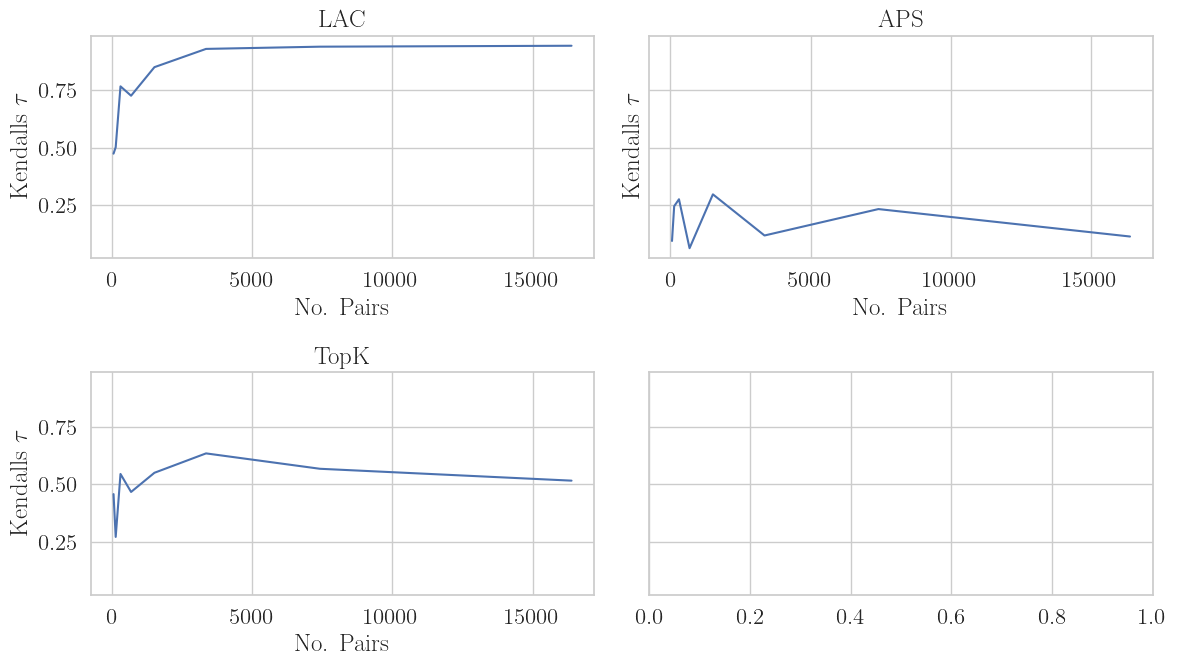

: 

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5,rc={'text.usetex' : True})
sns.set_style("whitegrid")
plt.rc('font', **{'family': 'serif'})
plt.rcParams["figure.figsize"] = (12, 7)



fig, axes = plt.subplots(2,2, sharey=True)
axes = axes.ravel()

axes[0].set_title("LAC")
axes[0].set_ylabel(r"Kendalls $\tau$")
axes[0].set_xlabel(r"No. Pairs")
sns.lineplot(x=num_pairs_to_check, y=tau_corrs_LAC, ax = axes[0])
axes[1].set_title("APS")
axes[1].set_ylabel(r"Kendalls $\tau$")
axes[1].set_xlabel(r"No. Pairs")
sns.lineplot(x=num_pairs_to_check, y=tau_corrs_APS, ax = axes[1])
axes[2].set_title("TopK")
axes[2].set_ylabel(r"Kendalls $\tau$")
axes[2].set_xlabel(r"No. Pairs")
sns.lineplot(x=num_pairs_to_check, y=tau_corrs_TopK, ax = axes[2])
fig.tight_layout()
# axes[1].set_title("APS")
# axes[1].set_ylabel(r"Kendalls $\tau$")
# axes[1].set_xlabel(r"No. Pairs")
# sns.lineplot(x=num_pairs_to_check, y=tau_corrs_APS, ax = axes[1])

In [72]:
X_seed, y_seed = make_classification(n_samples=1000, n_features=3, n_classes=3, n_informative=3, n_redundant=0, n_repeated=0, n_clusters_per_class=1, random_state=42)
conformity_score = APSConformityScore()
generator = MultinomialSyntheticDataGenerator(random_state=42)
generator.fit(X_seed, y_seed)
X_cal, y_cal = generator.generate(n=100)
mapie_clf = MapieClassifier(estimator=generator, cv="prefit", conformity_score=conformity_score)
# create mapie classifier for conformity scores
mapie_clf.fit(X_cal, y_cal)
# create 
oracle_annotator = OracleAnnotator(mapie_clf, generator)

# generate all possible pairs for a couple of instances
n_instances = 10
n_classes = len(generator.classes_)
n_obs = n_instances * n_classes
X_train = generator.generate_instances(n_instances).repeat(n_classes, axis=0)
y_train = np.tile(generator.classes_, n_instances)
conformities = oracle_annotator.get_conformity(X_train,y_train)
sort_idx = (-conformities).argsort(axis=0).flatten()

X_sorted = X_train[sort_idx]
y_sorted = y_train[sort_idx]
conformities_sorted = conformities[sort_idx]

X_pairs = np.array([(X_sorted[i], X_sorted[j]) for i in range(len(X_sorted)) for j in range(i + 1, len(X_sorted))])
y_pairs = np.array([(y_sorted[i], y_sorted[j]) for i in range(len(y_sorted)) for j in range(i + 1, len(y_sorted))])
y_pairs = np.expand_dims(y_pairs, axis=-1)


ds = LabelPairDataset()
ds.create_from_numpy_pairs(X_pairs, y_pairs)
for x,y in ds:
    print(x,y)
print(len(ds))
model = LabelRankingModel(input_dim=generator.n_features_, hidden_dims=3*[generator.n_features_], activations=[torch.nn.Sigmoid(), SortLayer(),torch.nn.Identity()], output_dim=len(generator.classes_))

pair_loader = DataLoader(ds, batch_size=32)
model.num_classes = generator.n_classes_
model._fit(pair_loader, val_loader=pair_loader, num_epochs=250, learning_rate=0.001, verbose=True)


# # generate data from data generating process and check whether the learned non-conformity relation sorts them correctly
# X_test, y_test = X_train, y_train
# conformity_scores = oracle_annotator.get_conformity(X_test, y_test)
# skills_from_model = np.take_along_axis(model.predict_class_skills(X_test), y_test[:,np.newaxis], axis=1)
# tau_corr, p_value = kendalltau(skills_from_model, conformity_scores)
# print("in-sample: ", tau_corr)
# X_test, y_test = generator.generate(n=10)
# conformity_scores = oracle_annotator.get_conformity(X_test, y_test)
# skills_from_model = np.take_along_axis(model.predict_class_skills(X_test), y_test[:,np.newaxis], axis=1)
# tau_corr, p_value = kendalltau(skills_from_model, conformity_scores)
# print("out-of-sample: ", tau_corr)


c:\Users\jonas\anaconda3\envs\cp_rank\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


tensor([[-1.1926,  4.2098,  0.9399],
        [-0.4712, -0.8476, -0.0779]], device='cuda:0') tensor([[2],
        [0]], device='cuda:0')
tensor([[-1.1926,  4.2098,  0.9399],
        [-2.6466,  2.2308,  1.7689]], device='cuda:0') tensor([[2],
        [2]], device='cuda:0')
tensor([[-1.1926,  4.2098,  0.9399],
        [-1.1098,  1.7773,  0.4134]], device='cuda:0') tensor([[2],
        [2]], device='cuda:0')
tensor([[-1.1926,  4.2098,  0.9399],
        [-1.1367, -0.4950, -1.5344]], device='cuda:0') tensor([[2],
        [1]], device='cuda:0')
tensor([[-1.1926,  4.2098,  0.9399],
        [-1.2317,  1.1304, -1.3616]], device='cuda:0') tensor([[2],
        [1]], device='cuda:0')
tensor([[-1.1926,  4.2098,  0.9399],
        [-1.0532, -1.2685, -0.5828]], device='cuda:0') tensor([[2],
        [0]], device='cuda:0')
tensor([[-1.1926,  4.2098,  0.9399],
        [-2.6466,  2.2308,  1.7689]], device='cuda:0') tensor([[2],
        [0]], device='cuda:0')
tensor([[-1.1926,  4.2098,  0.9399],
        [-1

In [73]:
len(pair_loader)

14

In [ ]:
n_instances = 10
n_classes = len(generator.classes_)
n_obs = n_instances * n_classes
X_train = generator.generate_instances(n_instances).repeat(n_classes, axis=0)
y_train = np.tile(generator.classes_, n_instances)
conformities = oracle_annotator.get_conformity(X_train,y_train)
sort_idx = (-conformities).argsort(axis=0).flatten()

X_sorted = X_train[sort_idx]
y_sorted = y_train[sort_idx]
conformities_sorted = conformities[sort_idx]

X_pairs = np.array([(X_sorted[i], X_sorted[j]) for i in range(len(X_sorted)) for j in range(i + 1, len(X_sorted))])
y_pairs = np.array([(y_sorted[i], y_sorted[j]) for i in range(len(y_sorted)) for j in range(i + 1, len(y_sorted))])
y_pairs = np.expand_dims(y_pairs, axis=-1)
ds = LabelPairDataset()
ds.create_from_numpy_pairs(X_pairs, y_pairs)
for x,y in ds:
    print(x,y)
pair_loader = DataLoader(ds, batch_size=32)
# ds_val = LabelPairDataset()
# ds_val.create_from_numpy_pairs(X_pairs, y_pairs)
# val_loader = DataLoader(ds_val, batch_size=32, num_workers=6)
# print(len(ds))
model = LabelRankingModel(input_dim=generator.n_features_, hidden_dims=3*[generator.n_features_], activations=[torch.nn.Sigmoid(), SortLayer(),torch.nn.Identity()], output_dim=len(generator.classes_))
model.num_classes = generator.n_classes_
print(len(pair_loader))
# device = next(model.parameters()).device
# print(f"Model is on: {device}")
model._fit(pair_loader, val_loader=pair_loader, num_epochs=250, learning_rate=0.001, verbose=True)


# # generate data from data generating process and check whether the learned non-conformity relation sorts them correctly
# X_test, y_test = generator.generate(n=100)
# skills_from_model = np.take_along_axis(model.predict_class_skills(X_test), y_test[:,np.newaxis], axis=1)
# conformity_scores = oracle_annotator.get_conformity(X_test, y_test)
# tau_corr, p_value = kendalltau(skills_from_model, conformity_scores)


tensor([[-1.3553,  1.3900, -2.2718],
        [-1.7794,  3.7924,  1.9101]], device='cuda:0') tensor([[1],
        [2]], device='cuda:0')
tensor([[-1.3553,  1.3900, -2.2718],
        [-0.2696, -1.9312, -1.6093]], device='cuda:0') tensor([[1],
        [1]], device='cuda:0')
tensor([[-1.3553,  1.3900, -2.2718],
        [-0.2663,  2.1617, -0.6311]], device='cuda:0') tensor([[1],
        [2]], device='cuda:0')
tensor([[-1.3553,  1.3900, -2.2718],
        [-3.1908,  2.8808,  0.8630]], device='cuda:0') tensor([[1],
        [2]], device='cuda:0')
tensor([[-1.3553,  1.3900, -2.2718],
        [-0.2583, -0.3482,  1.0580]], device='cuda:0') tensor([[1],
        [0]], device='cuda:0')
tensor([[-1.3553,  1.3900, -2.2718],
        [-2.0302, -0.0881,  1.1705]], device='cuda:0') tensor([[1],
        [0]], device='cuda:0')
tensor([[-1.3553,  1.3900, -2.2718],
        [-1.3553,  1.3900, -2.2718]], device='cuda:0') tensor([[1],
        [2]], device='cuda:0')
tensor([[-1.3553,  1.3900, -2.2718],
        [ 0

: 